# Qiskit Summer School Final Project: VQE

#### For this optional final challenge, you will be designing your own implementation of a variational quantum eigensolver (VQE) algorithm that simulates the ground state energy of the Lithium Hydride (LiH) molecule. Through out this challenge, you will be able to make choices on how you want to compose your simulation and what is the final deliverable that you want to showcase to your classmates and friends.#  IMPORT STATEMENTS

## Import Statements

In [2]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver, NumPyEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer import noise
provider = IBMQ.load_account()
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

## Classically solve for the lowest eigenvalue

In [3]:
def exact_solver(qubitOp,shift):
    ee = NumPyEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy'] + shift
    return np.real(ref)

## Simulation backend

In [4]:
backend=Aer.get_backend('qasm_simulator')

## MAPPING TYPE

In [5]:
map_type="parity"

## Noise Model

In [6]:
#Define our noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

## Define your function for computing the qubit operations of LiH

In [7]:
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
#     print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
#     print("# of electrons: {}".format(num_particles))
#     print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + molecule.nuclear_repulsion_energy
    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift

## Execute the VQE algorithm for different values of inter_dist

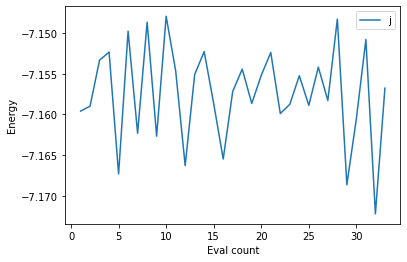

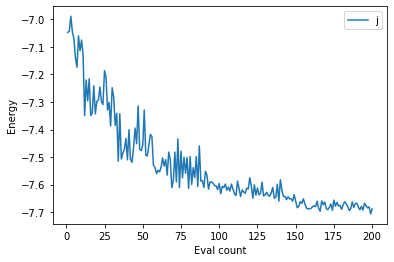

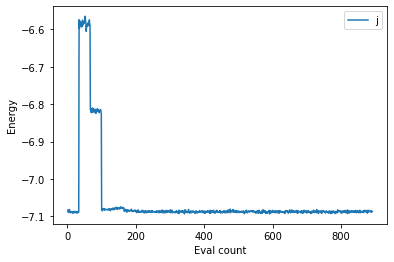

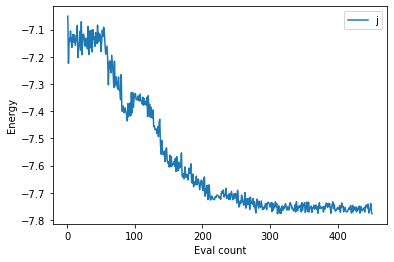

All energies have been calculated


In [10]:
inter_dist=1.6

def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)

# counts=[]
# values=[]
# params=[]
# deviation=[]


count_dict = {}
values_dict = {}
params_dict = {}
deviation_dict = {}

# Choose the classical optimizer
for i in range(4):
    counts=[]
    values=[]
    params=[]
    deviation=[]

    
    if i==0:
        optimizer = SLSQP(maxiter=100)
    if i==1:
        optimizer = COBYLA(maxiter=200)
    if i==2:
        optimizer = L_BFGS_B(maxiter=100)
    if i==3:
        optimizer = SPSA(max_trials=200)

    #Call the compute_LiH_qubitOp function
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction,shift = compute_LiH_qubitOp(map_type,inter_dist)

    #Call the exact_solver for reference value
    ref = exact_solver(qubitOp,shift)
  

    # Specify your initial state
    init_state = HartreeFock(num_orbitals=num_spin_orbitals, 
                             num_particles=num_particles, 
                             qubit_mapping=map_type)

    # Select a state preparation ansatz
    var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear")

    quantum_instance = QuantumInstance(backend=backend, 
                                       shots=1000, 
                                       noise_model=noise_model, 
                                       coupling_map=coupling_map,
                                       measurement_error_mitigation_cls=CompleteMeasFitter,
                                       cals_matrix_refresh_period=30)
    # Run your VQE instance
    vqe = VQE(qubitOp, var_form, optimizer,callback=store_intermediate_result)
    vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'] + shift)   
    
    count_dict[i] = counts
    values_dict[i] = values
    params_dict[i] = params
    deviation_dict[i] = deviation
    plt.plot(count_dict[i], values_dict[i]+shift, label="j")
    plt.xlabel('Eval count')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()
print("All energies have been calculated")  

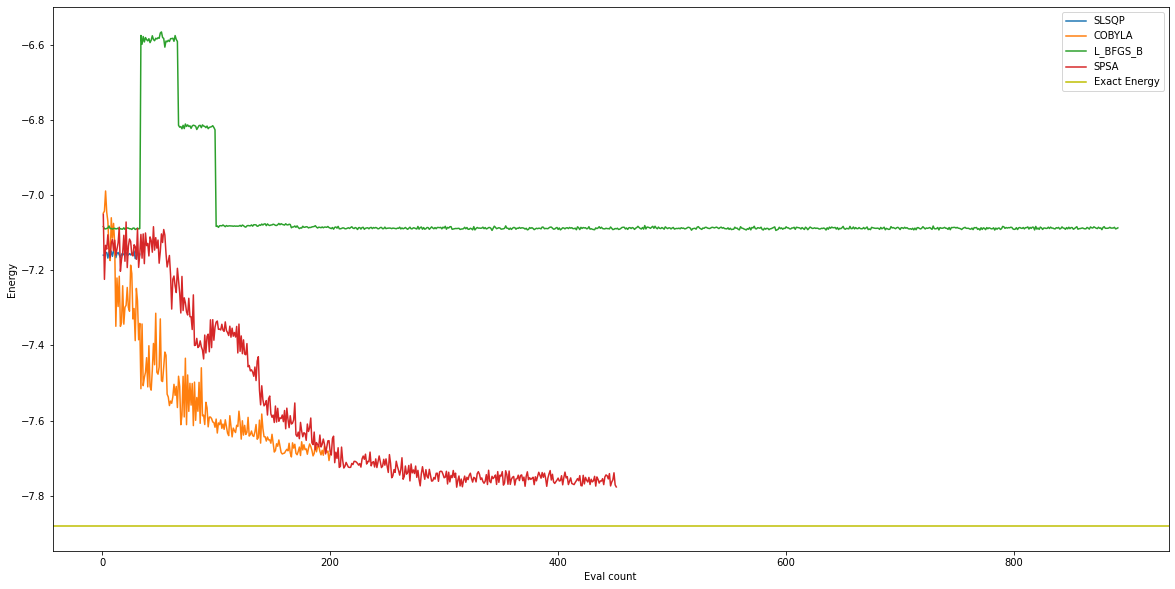

<Figure size 3600x1800 with 0 Axes>

In [24]:
plt.figure(figsize=(20,10))
plt.plot(count_dict[0], values_dict[0]+shift, label="SLSQP")
plt.plot(count_dict[1], values_dict[1]+shift, label="COBYLA")
plt.plot(count_dict[2], values_dict[2]+shift, label="L_BFGS_B")
plt.plot(count_dict[3], values_dict[3]+shift, label="SPSA")
plt.axhline(y=-7.88107204403092,label="Exact Energy",color='y')
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.legend()
plt.figure(figsize=(50,25))
plt.show()